# Лекция №7. XGBoost.

### Пример.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Разберём задачу, в которой нужно предсказать доход человека (больше $50000 или меньше) по результатам переписи населения.
https://archive.ics.uci.edu/ml/datasets/Adult

Описание данных:
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('adult.data', header=None, names=columns, na_values=' ?')
# Удаляем колонку education (потому что есть уже закодированная колонка education-num)
df = df.drop('education', axis=1)
# Кодируем отклик в бинарные значения
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
# удаляем строки с NA значениями
df = df.dropna()

test = pd.read_csv('adult.test', header=None, names=columns, na_values=' ?', skiprows=1)
test = test.drop('education', axis=1)
test['income'] = test['income'].map({' <=50K.': 0, ' >50K.': 1})
test = test.dropna()

In [3]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Посчитаем распределение классов в отклике.

In [4]:
df['income'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income, dtype: float64

Бинаризуем категориальные признаки (эта операция ещё называется one-hot encoding). Затем отделяем предикторы от вектора откликов для обеих выборок. 

In [5]:
X_train = pd.get_dummies(df).drop('income', axis=1)
y_train = df['income']
X_test = pd.get_dummies(test).drop('income', axis=1)
y_test = test['income']

После бинаризации категориальных признаков оказалось, что в обучающем множестве содержится на одну колонку больше. Причина: в тестовую выборку не попал ни один представитель Голландии (см. колонку native-county). Проверяем

In [6]:
print (len(X_train.columns))
print (len(X_test.columns))
# Приводим множество названий колонок к типу set, находим разность двух множеств.
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

88
87
{'native-country_ Holand-Netherlands'}
set()


Исправляем. Создадим полный список всех колонок (из трейна и из теста) и переиндексируем колонки в соответствии с этим списком. В результате в колонке native-country_ Holand-Netherlands в тестовом множестве появятся NaN-значения, которые мы заменим на нули.

In [7]:
columns = set(X_train.columns) | set(X_test.columns)
X_train = X_train.reindex(columns=columns).fillna(0)
X_test = X_test.reindex(columns=columns).fillna(0)

Теперь колонки в обучающей и тестовой выборках должны быть идентичными. В том числе идентичным должен быть и порядок колонок. На всякий случай проверим.

In [8]:
# Команда all проверяет, все ли значения из входного списка равны True
all(X_train.columns == X_test.columns)

True

XGBoost

In [9]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [10]:
model = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print (classification_report(y_train, y_pred_train))

y_pred = model.predict(X_test)
print (classification_report(y_test, y_pred))

c:\users\bokoser_user\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:37] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     22654
           1       0.84      0.73      0.78      7508

    accuracy                           0.90     30162
   macro avg       0.88      0.84      0.86     30162
weighted avg       0.90      0.90      0.90     30162

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11360
           1       0.77      0.66      0.71      3700

    accuracy                           0.87     15060
   macro avg       0.83      0.80      0.81     15060
weighted avg       0.86      0.87      0.87     15060



В библиотеке существует возможность проанализировать важность переменных, т.е. вклад их в результат работы алгоритма (в данном случае - вклад в F-score).

In [11]:
import xgboost as xgb

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

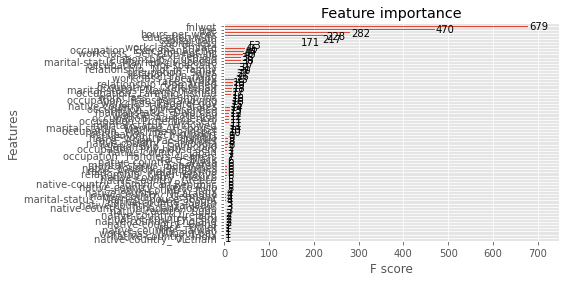

In [12]:
xgb.plot_importance(model)

Когда предикторов слишком много, график становится нечитаемым. Ограничим отображаемое число предикторов.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

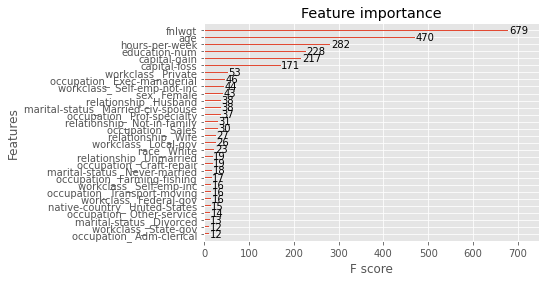

In [13]:
xgb.plot_importance(model, max_num_features = 30)